In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import json
import os
import gdown

from torchvision.models import mobilenet_v3_large
from pathlib import Path
from PIL import Image
from torchvision import transforms, utils
from torch.utils.data import DataLoader

from fairface_classification import data, utils

utils.set_random_seed(42)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
train_label

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True
...,...,...,...,...,...
86739,train/86740.jpg,20-29,Male,Indian,True
86740,train/86741.jpg,10-19,Male,Indian,True
86741,train/86742.jpg,more than 70,Female,Indian,True
86742,train/86743.jpg,10-19,Female,Black,True


In [3]:
mobilenet = mobilenet_v3_large(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 112MB/s]


### Unzip files

In [4]:
path = Path('../data/')

url = 'https://drive.google.com/uc?id=1n1wjPXLRlMrJjFdX1SxoiaO1JgwbQuFV'
output = path / 'fairface_dataset.zip'
# gdown.download(url, str(output), quiet=False)

In [5]:
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(path)

### Conduct basic EDA on how images look like

0 ../data/train/1346.jpg
1 ../data/train/1498.jpg
2 ../data/train/4904.jpg
3 ../data/train/10734.jpg


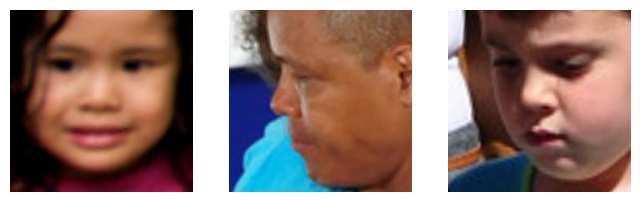

4 ../data/train/36231.jpg
5 ../data/train/42641.jpg
6 ../data/train/46173.jpg


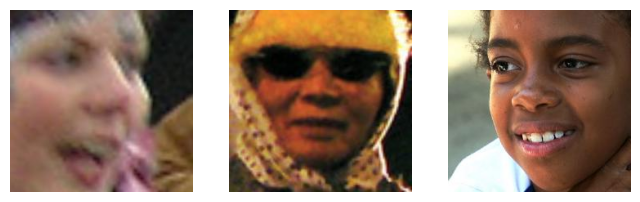

7 ../data/train/49036.jpg
8 ../data/train/49039.jpg
9 ../data/train/60572.jpg


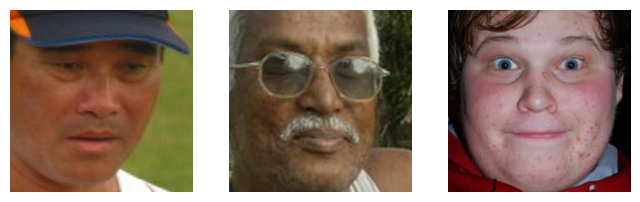

10 ../data/train/63324.jpg
11 ../data/train/1016.jpg
12 ../data/train/1759.jpg


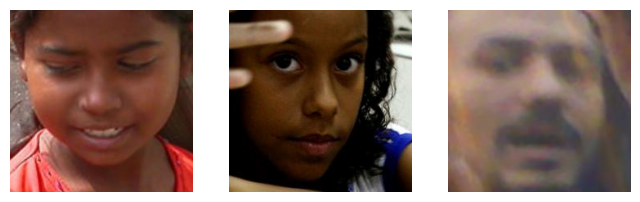

13 ../data/train/2805.jpg
14 ../data/train/13446.jpg
15 ../data/train/29789.jpg


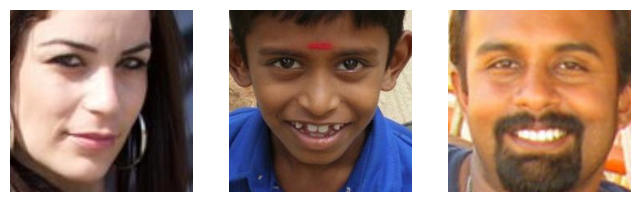

16 ../data/train/50357.jpg
17 ../data/train/51957.jpg


In [6]:
import os

root = Path('..')
data_path = Path('data')
plot_imgs = []

os.mkdir('../data/EDA_images')

for i, file in enumerate((root / data_path / 'train').glob('*')):
    print(i, file)
    if i > 16:
        break
    if i % 3 == 0 and i != 0:
        fig, axs = plt.subplots(1, 3, figsize=(8, 4))
        image1 = Image.open(plot_imgs[0]).convert('RGB')
        image2 = Image.open(plot_imgs[1]).convert('RGB')
        image3 = Image.open(plot_imgs[2]).convert('RGB')
        axs[0].imshow(np.array(image1))
        axs[1].imshow(np.array(image2))
        axs[2].imshow(np.array(image3))
        axs[0].axis('off')
        axs[1].axis('off')
        axs[2].axis('off')
        plt.show()
        fig.savefig(root / data_path / 'EDA_images' / f'{file.stem}.png');
        plot_imgs = []
    plot_imgs.append(file)

### Check labels of the train dataset

In [7]:
train_label['age'].value_counts(normalize=True) * 100

age
20-29           29.509822
30-39           22.191737
40-49           12.385871
3-9             11.998524
10-19           10.494098
50-59            7.179747
60-69            3.203680
0-2              2.065849
more than 70     0.970672
Name: proportion, dtype: float64

In [8]:
train_label['race'].value_counts(normalize=True) * 100

race
White              19.052615
Latino_Hispanic    15.409711
Indian             14.201559
East Asian         14.164668
Black              14.102416
Southeast Asian    12.444665
Middle Eastern     10.624366
Name: proportion, dtype: float64

In [9]:
train_label['gender'].value_counts(normalize=True) * 100

gender
Male      53.013465
Female    46.986535
Name: proportion, dtype: float64

### Check which combination is the most popular

the most popular human are white 20-29 y.o. female/male and east asian female with the same age group 

In [10]:
train_label.groupby(['age', 'race', 'gender']).agg({'age' : 'count'}).rename({'age' : 'age_col'}, axis=1).sort_values('age_col', ascending=False).head(50)

age_col
age   race            gender         
20-29 White           Female     2972
      East Asian      Female     2902
      White           Male       2249
30-39 White           Male       2228
20-29 Latino_Hispanic Female     2004
30-39 White           Female     1911
20-29 Southeast Asian Female     1871
      East Asian      Male       1863
30-39 Middle Eastern  Male       1782
20-29 Black           Female     1769
      Indian          Female     1704
      Southeast Asian Male       1639
30-39 Indian          Male       1607
      Latino_Hispanic Male       1557
20-29 Latino_Hispanic Male       1527
      Black           Male       1402
30-39 Latino_Hispanic Female     1375
20-29 Indian          Male       1373
40-49 White           Male       1365
30-39 Black           Female     1323
                      Male       1296
20-29 Middle Eastern  Male       1282
30-39 East Asian      Male       1267
3-9   Black           Male       1230
40-49 Middle Eastern  Male       1190
30-39 Indian          Female     1164
40-49 Latino_Hispanic Male       1125
30-39 East Asian      Female     1115
      Southeast Asian Male       1093
3-9   East Asian      Male       1061
20-29 Middle Eastern  Female     1041
40-49 Indian          Male        976
50-59 White           Male        969
10-19 Latino_Hispanic Female      918
30-39 Southeast Asian Female      916
10-19 Indian          Female      890
      Black           Female      850
3-9   Black           Female      842
      Latino_Hispanic Female      837
      Indian          Male        835
40-49 Latino_Hispanic Female      832
3-9   Southeast Asian Male        821
40-49 White           Female      814
      Black           Male        777
3-9   Latino_Hispanic Male        752
10-19 Southeast Asian Female      718
3-9   Southeast Asian Female      702
50-59 Latino_Hispanic Male        698
3-9   Indian          Female      695
10-19 Latino_Hispanic Male        691

### Create train test split

In [11]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
val_label = pd.read_csv('../data/fairface_label_val.csv')
train_data, test_data = data.train_test_split(train_label)

train_data.head()

,file,age,gender,race,service_test
0,train/47414.jpg,20-29,Male,Middle Eastern,True
1,train/52264.jpg,30-39,Male,Middle Eastern,False
2,train/21584.jpg,10-19,Female,Indian,False
3,train/32130.jpg,30-39,Male,Black,False
4,train/63301.jpg,10-19,Male,Indian,True


In [12]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
train_data, test_data = data.train_test_split(train_label)

In [13]:
# write to the root dir of the project
with open('../train_test_val.json', 'w') as outfile:
    json.dump({'train' : train_data['file'].tolist(), 
               'test' : test_data['file'].tolist(), 
               'val' : val_label['file'].tolist()}, 
               outfile)

### Create encodings for labels

In [14]:
race_dict = dict(enumerate(['White', 'Latino_Hispanic', 'Indian', 'East Asian', 'Black', 'Southeast Asian', 'Middle Eastern']))
gender_dict = dict(enumerate(['Male', 'Female']))
age_dict = dict(enumerate(['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']))

race_dict = {v : k for (k, v) in race_dict.items()}
gender_dict = {v : k for (k, v) in gender_dict.items()}
age_dict = {v : k for (k, v) in age_dict.items()}

save_folder = '../data/encodings/'
encod_dicts = [race_dict, gender_dict, age_dict]
name_encod = ['race_encoding.json', 'gender_encoding.json', 'age_encoding.json']
name_encod = [save_folder + file for file in name_encod]

if 'encodings' not in os.listdir('../data/'):
    os.mkdir(save_folder)

for i in range(len(encod_dicts)):
    data.write_json(encod_dicts[i], name_encod[i])

### All images are (224, 224) resolution so there is no need to make rescaling before MobileNetV3 large model input

In [15]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}

In [17]:
fairface_dataset = data.FairFaceDataset('fairface_label_train.csv',
                               root_dir='/home/Fairface-Face-Classification',
                               mode='train', encoders=encoders, transform=transforms.Compose([transforms.ToTensor(),
                                                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                                                           std=[0.229, 0.224, 0.225])]))


### Explore how images look like after normalization

In [18]:
# Check how tranformings were applied to the fairface dataset
for i, sample in enumerate(fairface_dataset):
    print(i ,sample['image'].size(), sample['race'], sample['gender'], sample['age'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 3 0 6
1 torch.Size([3, 224, 224]) 2 1 4
2 torch.Size([3, 224, 224]) 2 1 3
3 torch.Size([3, 224, 224]) 2 1 3


### Start using Dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([4, 3, 224, 224]) tensor([4, 1, 0, 4]) tensor([1, 1, 1, 0]) tensor([4, 3, 3, 3])
1 torch.Size([4, 3, 224, 224]) tensor([2, 2, 6, 3]) tensor([0, 1, 1, 1]) tensor([4, 3, 3, 2])
2 torch.Size([4, 3, 224, 224]) tensor([2, 6, 2, 6]) tensor([1, 1, 1, 0]) tensor([4, 3, 2, 3])
3 torch.Size([4, 3, 224, 224]) tensor([0, 0, 2, 2]) tensor([1, 0, 1, 0]) tensor([3, 3, 6, 4])


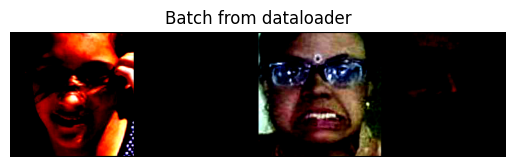

In [21]:
dataloader = DataLoader(fairface_dataset, batch_size=4, shuffle=True, num_workers=5)

def show_images_batch(sample_batched):
    images_batch = sample_batched['image']

    grid = torchvision.utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['race'], sample_batched['gender'], sample_batched['age'])

    if i_batch == 3:
        plt.figure()
        show_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
